**1. Importing the Dependencies**

In [1]:
# !pip uninstall catboost -y
!pip install catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    cohen_kappa_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score, f1_score
)
import pickle
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.impute import SimpleImputer

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


**2. Data Loading**


In [2]:
df = pd.read_csv("/content/train.csv")

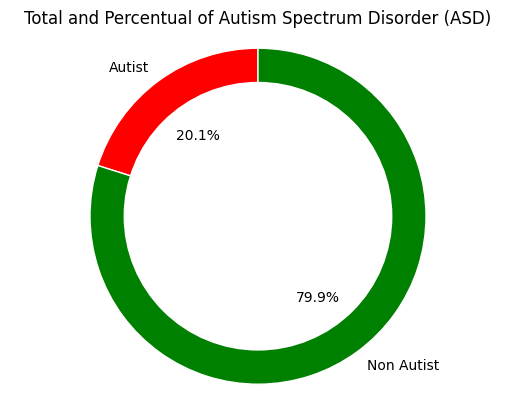

In [3]:
autism_map = {1: 'Autist', 0: 'Non Autist'}
autism_colors = ['red', 'green']

total_count = len(df)
autist_count = df['Class/ASD'].sum()
non_autist_count = total_count - autist_count

autist_percent = autist_count / total_count * 100
non_autist_percent = non_autist_count / total_count * 100

fig, ax = plt.subplots()

ax.pie([autist_percent, non_autist_percent], labels=[f'Autist', f'Non Autist'],
       autopct='%1.1f%%', startangle=90, colors=autism_colors, wedgeprops=dict(width=.4, edgecolor='w'))

centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

plt.title('Total and Percentual of Autism Spectrum Disorder (ASD)')
plt.show()

Text(0.5, 0.98, 'Relationship between Age Distribution and Autism Spectrum Disorder (ASD)')

<Figure size 1200x800 with 0 Axes>

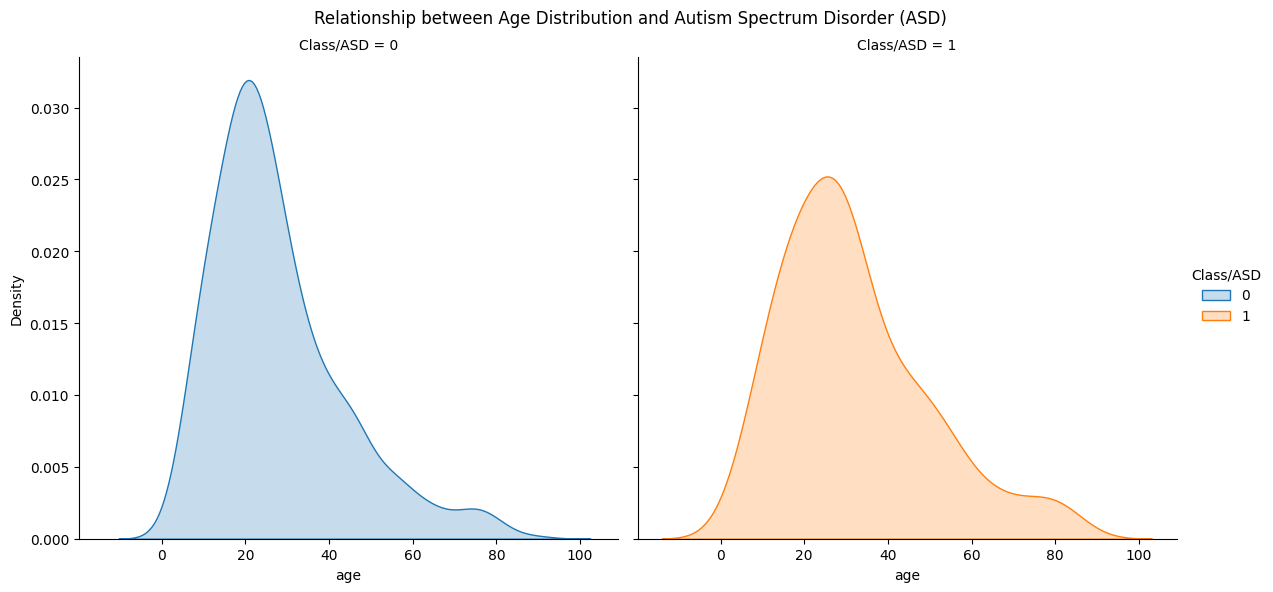

In [4]:
# Plotting the relationship between age distribution and Class/ASD
plt.figure(figsize=(12, 8))
g = sns.FacetGrid(df, col='Class/ASD', hue='Class/ASD', height=6)
g.map(sns.kdeplot, 'age', fill=True)
g.add_legend()

# Setting labels and title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Relationship between Age Distribution and Autism Spectrum Disorder (ASD)')

# Display the plot

Initial Inspection

In [5]:
df.shape

(800, 22)

In [6]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [7]:
df.tail()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
795,796,0,1,0,0,0,0,0,0,1,...,m,Hispanic,no,no,New Zealand,no,12.999501,18 and more,Self,0
796,797,0,1,1,0,0,1,0,1,1,...,m,White-European,no,no,Cyprus,no,13.561518,18 and more,Self,0
797,798,0,0,0,0,0,0,0,0,0,...,m,South Asian,yes,no,New Zealand,no,2.653177,18 and more,Self,0
798,799,0,0,0,0,0,0,0,0,0,...,f,?,no,no,Canada,no,9.069342,18 and more,Self,0
799,800,0,1,0,0,0,0,0,0,0,...,f,?,no,no,United Arab Emirates,yes,2.243304,18 and more,Self,0


In [8]:
#display all columns
pd.set_option('display.max_columns', None)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [10]:
#conversion of age to integer
df["age"] = df["age"].astype(int)

In [11]:
df.head(2)

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,1,38,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,0,47,m,?,no,no,India,no,2.255185,18 and more,Self,0


In [12]:
for col in df.columns:
  numerical_features = ["ID", "age", "result"]
  if col not in numerical_features:
    print(col,df[col].unique())
    print("-"*50)

A1_Score [1 0]
--------------------------------------------------
A2_Score [0 1]
--------------------------------------------------
A3_Score [1 0]
--------------------------------------------------
A4_Score [0 1]
--------------------------------------------------
A5_Score [1 0]
--------------------------------------------------
A6_Score [0 1]
--------------------------------------------------
A7_Score [1 0]
--------------------------------------------------
A8_Score [0 1]
--------------------------------------------------
A9_Score [1 0]
--------------------------------------------------
A10_Score [1 0]
--------------------------------------------------
gender ['f' 'm']
--------------------------------------------------
ethnicity ['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others']
--------------------------------------------------
jaundice ['no' 'yes']
--------------------------------------------------
austim

In [13]:
#dropping ID and age_desc column
df = df.drop(columns=["ID", "age_desc"])

In [14]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

In [15]:
df["contry_of_res"].unique()

array(['Austria', 'India', 'United States', 'South Africa', 'Jordan',
       'United Kingdom', 'Brazil', 'New Zealand', 'Canada', 'Kazakhstan',
       'United Arab Emirates', 'Australia', 'Ukraine', 'Iraq', 'France',
       'Malaysia', 'Viet Nam', 'Egypt', 'Netherlands', 'Afghanistan',
       'Oman', 'Italy', 'AmericanSamoa', 'Bahamas', 'Saudi Arabia',
       'Ireland', 'Aruba', 'Sri Lanka', 'Russia', 'Bolivia', 'Azerbaijan',
       'Armenia', 'Serbia', 'Ethiopia', 'Sweden', 'Iceland', 'Hong Kong',
       'Angola', 'China', 'Germany', 'Spain', 'Tonga', 'Pakistan', 'Iran',
       'Argentina', 'Japan', 'Mexico', 'Nicaragua', 'Sierra Leone',
       'Czech Republic', 'Niger', 'Romania', 'Cyprus', 'Belgium',
       'Burundi', 'Bangladesh'], dtype=object)

In [16]:
#mapping dictionary for country cells
mapping = {
    "Viet Nam": "Vietnam",
    "AmericanSamoa":"United States",
    "Hong Kong": "China"
}

#replacing values in country column
df["contry_of_res"] = df["contry_of_res"].replace(mapping)

In [17]:
df["contry_of_res"].unique()

array(['Austria', 'India', 'United States', 'South Africa', 'Jordan',
       'United Kingdom', 'Brazil', 'New Zealand', 'Canada', 'Kazakhstan',
       'United Arab Emirates', 'Australia', 'Ukraine', 'Iraq', 'France',
       'Malaysia', 'Vietnam', 'Egypt', 'Netherlands', 'Afghanistan',
       'Oman', 'Italy', 'Bahamas', 'Saudi Arabia', 'Ireland', 'Aruba',
       'Sri Lanka', 'Russia', 'Bolivia', 'Azerbaijan', 'Armenia',
       'Serbia', 'Ethiopia', 'Sweden', 'Iceland', 'China', 'Angola',
       'Germany', 'Spain', 'Tonga', 'Pakistan', 'Iran', 'Argentina',
       'Japan', 'Mexico', 'Nicaragua', 'Sierra Leone', 'Czech Republic',
       'Niger', 'Romania', 'Cyprus', 'Belgium', 'Burundi', 'Bangladesh'],
      dtype=object)

In [18]:
#target class distribution
df["Class/ASD"].value_counts()

,count
Class/ASD,
0,639
1,161


**Insights:**
1. Missing values ion ethnicity and relation
2. age_desc has only 1 unique value. so it is removed
3. Fixed country names
4. Identified class imbalance in target column

3. **Exploratory Data Analysis**

In [19]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

In [20]:
df.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,27.963750,8.537303,0.201250
std,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.329827,4.807676,0.401185
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-6.137748,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,5.306575,0.000000
50%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.000000,9.605299,0.000000
75%,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.250000,12.514484,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.000000,15.853126,1.000000


**Univariate Analysis**

Numerical Columns:
- age
- result

In [21]:
#setting theme
sns.set_theme(style="darkgrid")

Distribution plots

Mean: 27.96375
Median 24.0


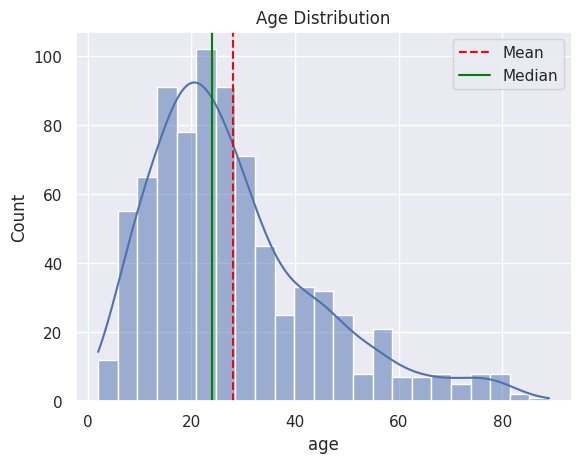

In [22]:
#Histogram for "age"
sns.histplot(df["age"], kde=True)
plt.title("Age Distribution")
#mean and median
age_mean = df["age"].mean()
age_median = df["age"].median()
print("Mean:", age_mean)
print("Median", age_median)
#vertical lines for mean and median
plt.axvline(age_mean, color='red', linestyle='--', label="Mean")
plt.axvline(age_median, color='green', linestyle='-', label="Median")
plt.legend()
plt.show()

Mean: 8.537303106501248
Median 9.605299308


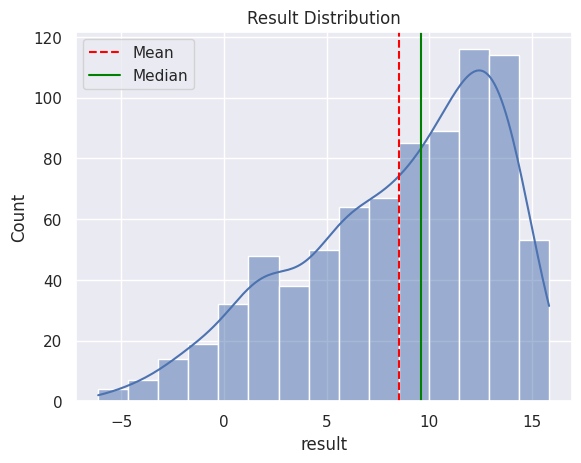

In [23]:
#Histogram for "result"
sns.histplot(df["result"], kde=True)
plt.title("Result Distribution")
#mean and median
result_mean = df["result"].mean()
result_median = df["result"].median()
print("Mean:", result_mean)
print("Median", result_median)
#vertical lines for mean and median
plt.axvline(result_mean, color='red', linestyle='--', label="Mean")
plt.axvline(result_median, color='green', linestyle='-', label="Median")
plt.legend()
plt.show()

**Box plots for identifying outliers in the numerical columns**

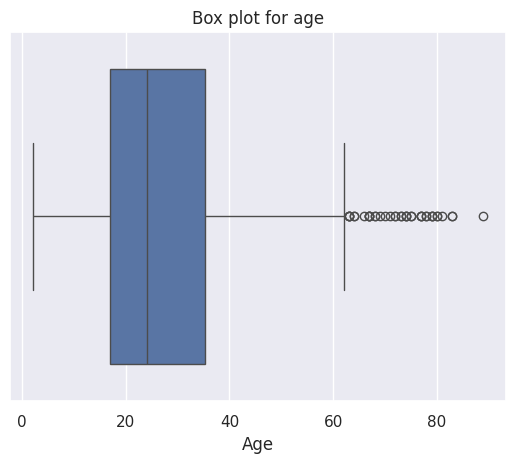

In [24]:
#box plot
sns.boxplot(x=df["age"])
plt.title("Box plot for age")
plt.xlabel("Age")
plt.show()

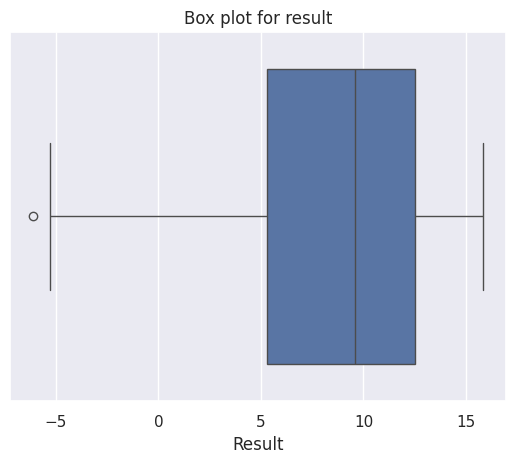

In [25]:
#box plot
sns.boxplot(x=df["result"])
plt.title("Box plot for result")
plt.xlabel("Result")
plt.show()

In [26]:
#counting outliers(IQR method)
Q1 = df["age"].quantile(0.25)
Q3 = df["age"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
age_outliers = df[(df["age"] < lower_bound) | (df["age"] > upper_bound)]

In [27]:
len(age_outliers)

39

In [28]:
#counting outliers(IQR method)
Q1 = df["result"].quantile(0.25)
Q3 = df["result"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
result_outliers = df[(df["result"] < lower_bound) | (df["result"] > upper_bound)]

In [29]:
len(result_outliers)

1

**Univariate Analysis of categorical columns**

In [30]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

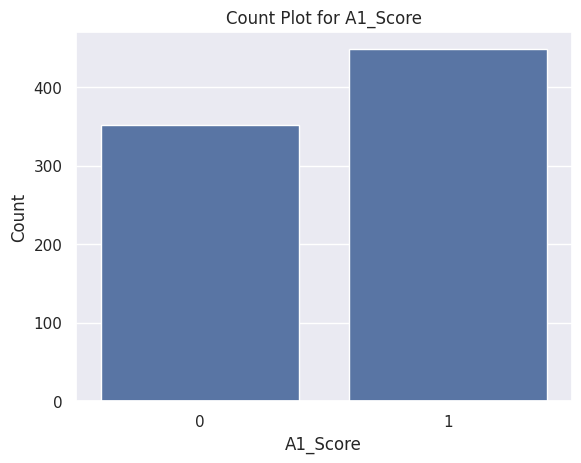

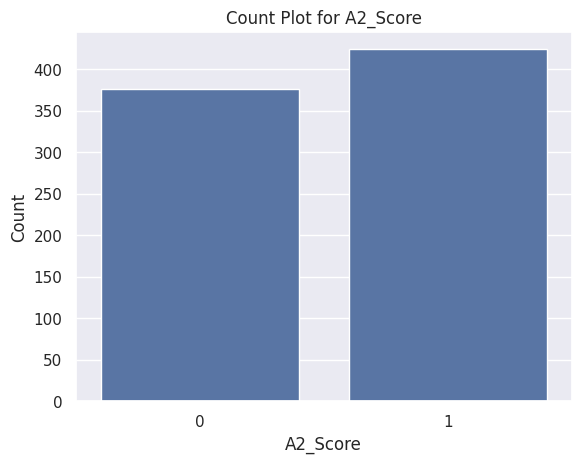

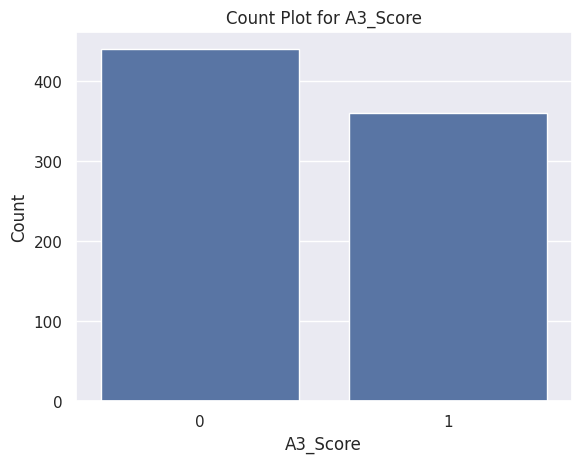

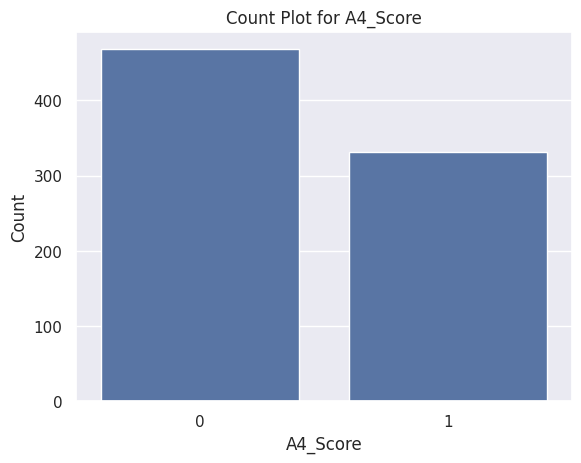

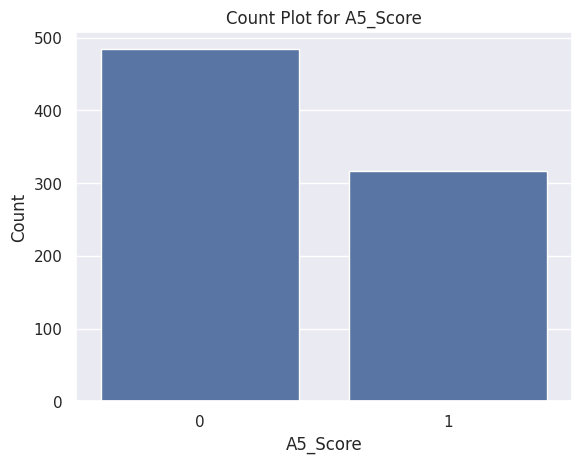

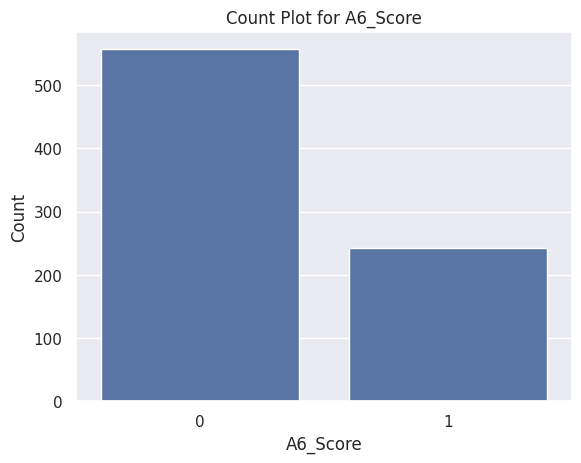

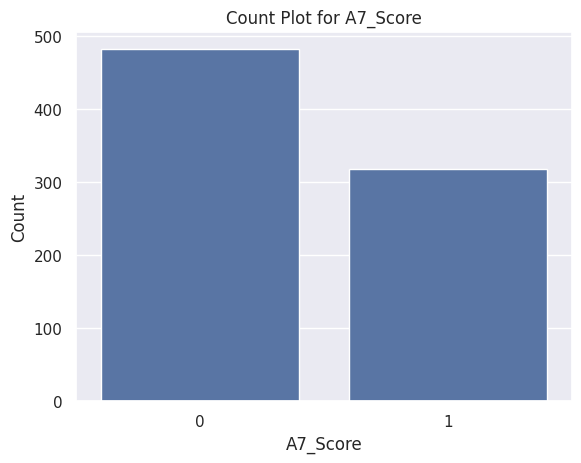

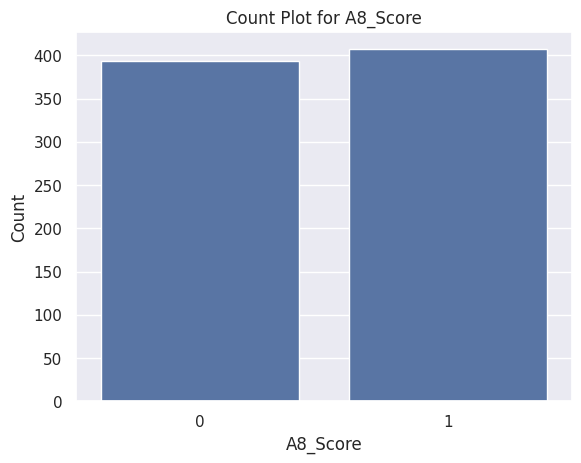

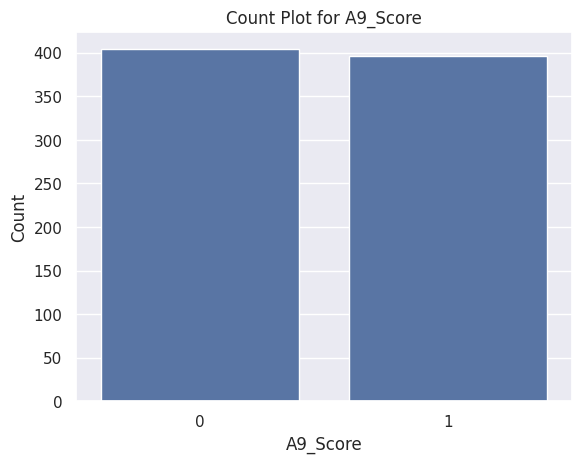

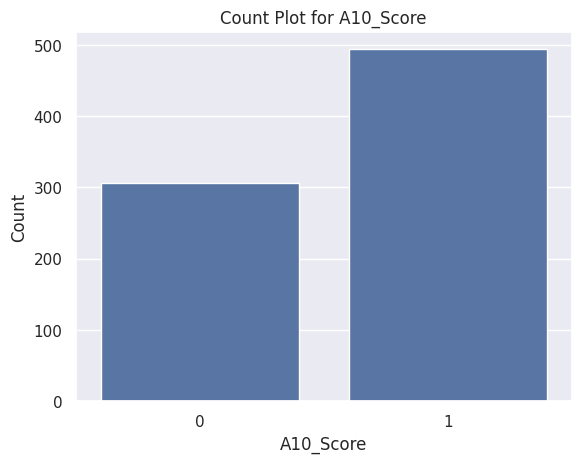

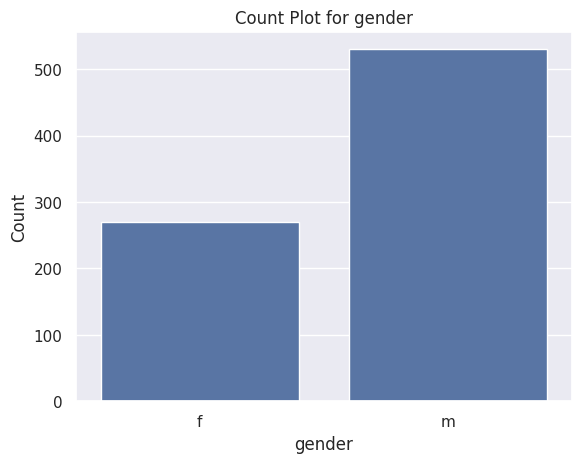

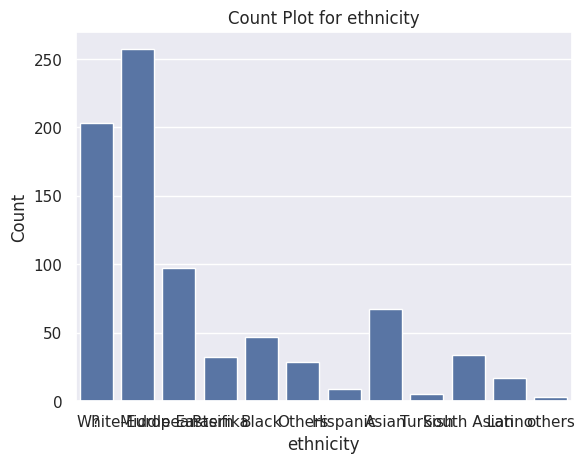

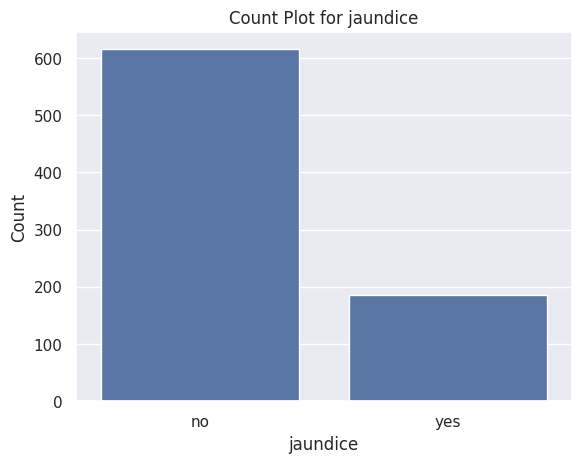

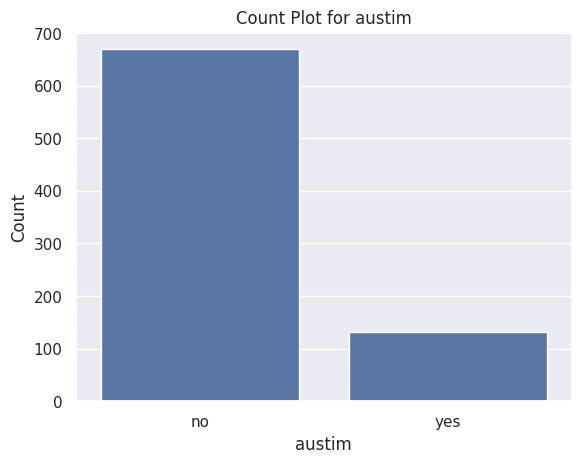

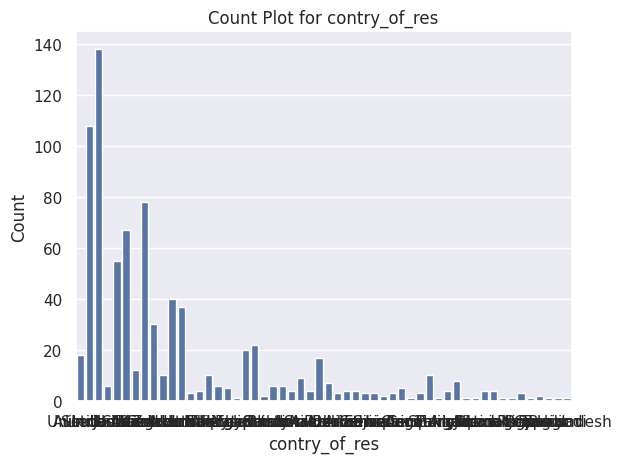

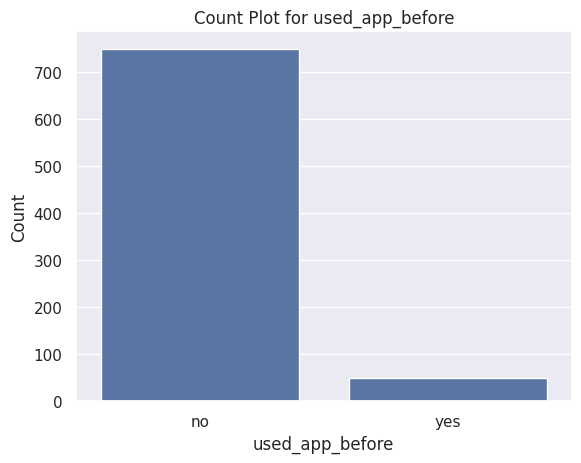

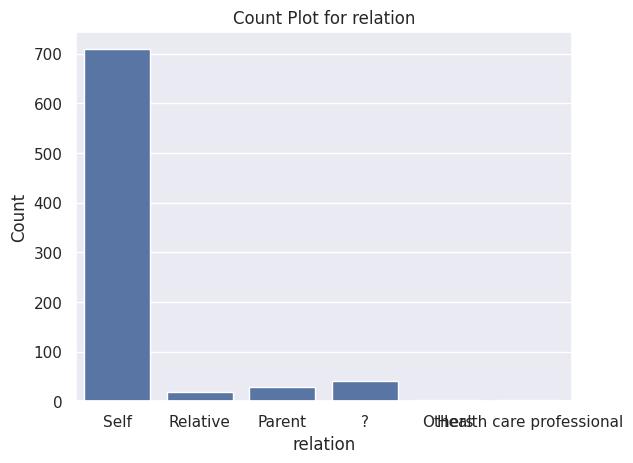

In [31]:
categorical_columns = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score',  'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
        'relation']
for col in categorical_columns:
  sns.countplot(x=df[col])
  plt.title(f"Count Plot for {col}")
  plt.xlabel(col)
  plt.ylabel("Count")
  plt.show()

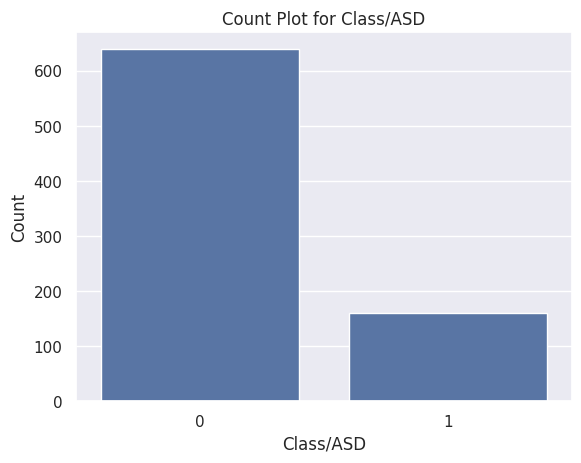

In [32]:
#countplot for target column(class/asd)
sns.countplot(x=df["Class/ASD"])
plt.title(f"Count Plot for Class/ASD")
plt.xlabel("Class/ASD")
plt.ylabel("Count")
plt.show()

In [33]:
df["Class/ASD"].value_counts()

,count
Class/ASD,
0,639
1,161


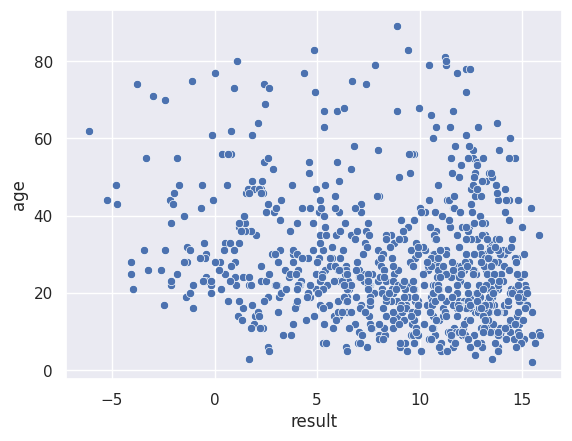

In [34]:
sns.scatterplot(y='age', x='result', data=df)
plt.show()

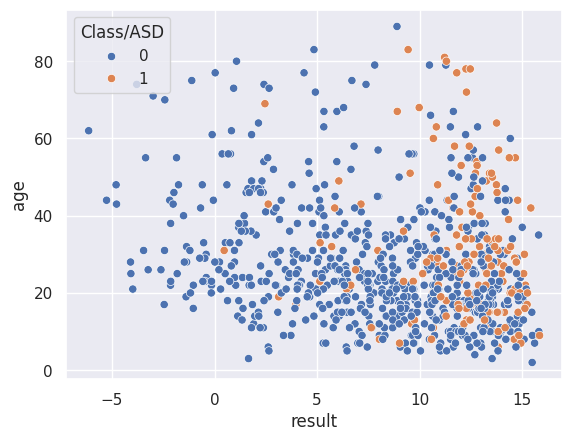

In [35]:
sns.scatterplot(y='age', x='result',hue='Class/ASD', data=df)
plt.show()

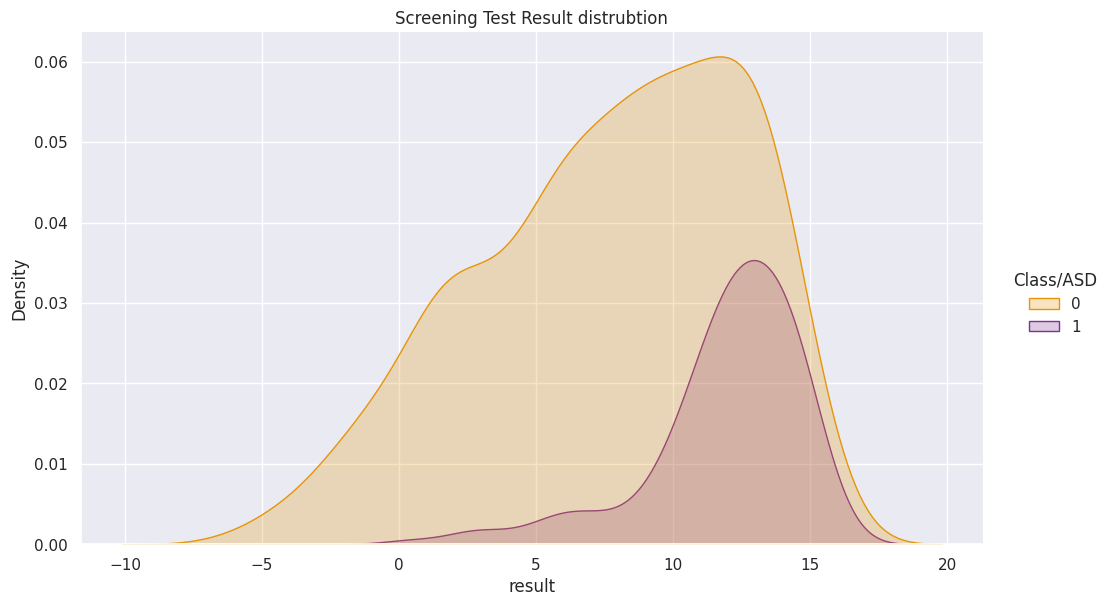

In [36]:
#The chart below shows that the result of those with Autism are higher than those without.
sns.displot(data=df,x='result',hue="Class/ASD" ,kind="kde", palette = "CMRmap_r",fill=True,height=6, aspect=1.7) ;
plt.title("Screening Test Result distrubtion")
plt.show()

**Handle missing values in ethnicity and relation**

In [37]:
df["ethnicity"] = df["ethnicity"].replace({"?": "Others", "others": "Others"})

In [38]:
df["ethnicity"].unique()

array(['Others', 'White-European', 'Middle Eastern ', 'Pasifika', 'Black',
       'Hispanic', 'Asian', 'Turkish', 'South Asian', 'Latino'],
      dtype=object)

In [39]:
df["relation"].unique()

array(['Self', 'Relative', 'Parent', '?', 'Others',
       'Health care professional'], dtype=object)

In [40]:
df["relation"] = df["relation"].replace(
    {"?": "Others",
     "Relative": "Others",
     "Parent": "Others",
     "Health care professional": "Others"}
)

In [41]:
df["relation"].unique()

array(['Self', 'Others'], dtype=object)

In [42]:
df.head(2)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,f,Others,no,no,Austria,no,6.351166,Self,0
1,0,0,0,0,0,0,0,0,0,0,47,m,Others,no,no,India,no,2.255185,Self,0


**Label Encoding**

In [43]:
#identify column with "object" datatype
object_columns = df.select_dtypes(include=["object"]).columns
print(object_columns)

Index(['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'used_app_before', 'relation'],
      dtype='object')


In [44]:
encoders = {}
#apply label encoding and store the encoders
for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column]= label_encoder

#save the encoders as pickle file
with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)


In [45]:
encoders

{'gender': LabelEncoder(),
 'ethnicity': LabelEncoder(),
 'jaundice': LabelEncoder(),
 'austim': LabelEncoder(),
 'contry_of_res': LabelEncoder(),
 'used_app_before': LabelEncoder(),
 'relation': LabelEncoder()}

In [46]:
df.head(2)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,0,5,0,0,6,0,6.351166,1,0
1,0,0,0,0,0,0,0,0,0,0,47,1,5,0,0,23,0,2.255185,1,0


**Bivariate Analysis**

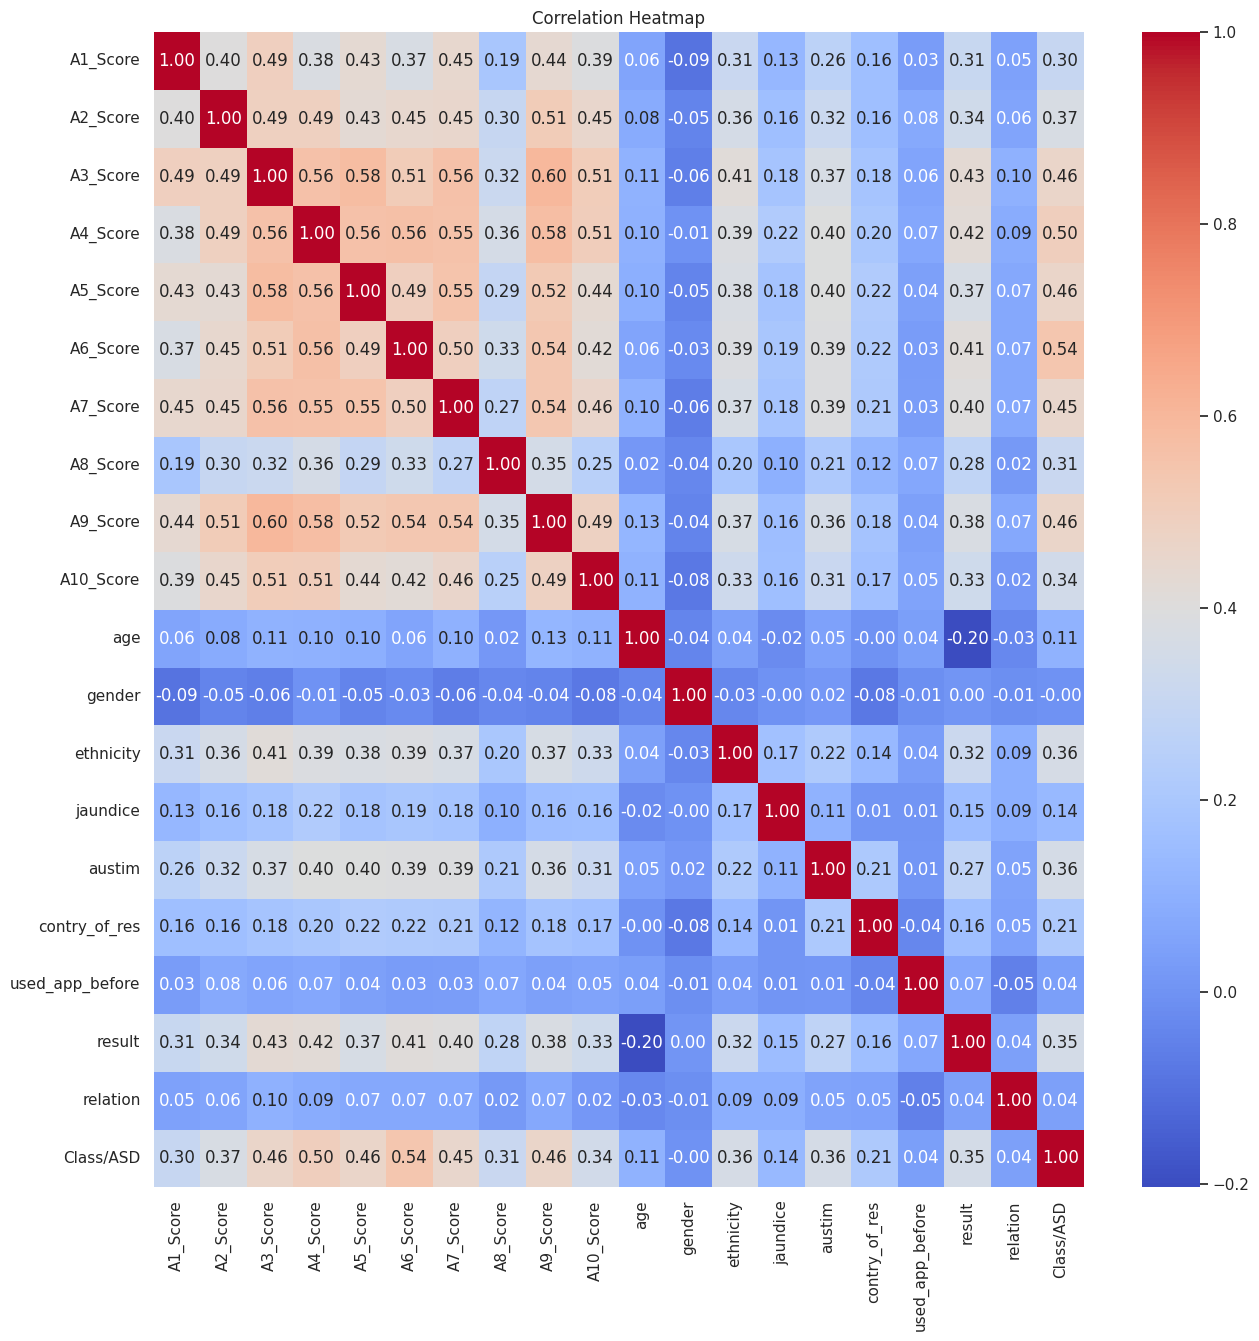

In [47]:
#correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**Insights from EDA**
- There are few outliers in numerical column (age, result)
- There is a class imbalance in target column
- There is a class imbalance inn categorical features
- we didn't have any highly correlated  column

**4. DATA PREPROCESSING**

Handling outliers

In [48]:
def replace_outliers_with_median(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  median = df[column].median()
  #replace with median value
  df[column] = df[column].apply(lambda x:median if x < lower_bound or x> upper_bound else x)
  return df

In [49]:
#replace outliers in age column
df = replace_outliers_with_median(df, "age")
df = replace_outliers_with_median(df, "result")

In [50]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38.0,0,5,0,0,6,0,6.351166,1,0
1,0,0,0,0,0,0,0,0,0,0,47.0,1,5,0,0,23,0,2.255185,1,0
2,1,1,1,1,1,1,1,1,1,1,7.0,1,9,0,1,52,0,14.851484,1,1
3,0,0,0,0,0,0,0,0,0,0,23.0,0,5,0,0,52,0,2.276617,1,0
4,0,0,0,0,0,0,0,0,0,0,43.0,1,5,0,0,44,0,-4.777286,1,0


**Train Test Split**

In [51]:
X = df.drop(columns=["Class/ASD"])
y = df["Class/ASD"]

In [52]:
print(X)

     A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0           1         0         1         0         1         0         1   
1           0         0         0         0         0         0         0   
2           1         1         1         1         1         1         1   
3           0         0         0         0         0         0         0   
4           0         0         0         0         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
795         0         1         0         0         0         0         0   
796         0         1         1         0         0         1         0   
797         0         0         0         0         0         0         0   
798         0         0         0         0         0         0         0   
799         0         1         0         0         0         0         0   

     A8_Score  A9_Score  A10_Score   age  gender  ethnicity  jaundice  aust

In [53]:
print(y)

0      0
1      0
2      1
3      0
4      0
      ..
795    0
796    0
797    0
798    0
799    0
Name: Class/ASD, Length: 800, dtype: int64


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train)
print("-"*50)
print(X_test)
print("-"*50)
print(y_train)
print("-"*50)
print(y_test)

     A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
264         1         1         1         1         1         1         1   
615         0         0         0         0         0         0         1   
329         1         0         0         0         0         0         0   
342         0         0         0         0         0         0         0   
394         1         1         0         1         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
71          0         1         0         0         0         0         0   
106         0         0         0         1         0         0         0   
270         1         0         0         0         1         0         0   
435         1         1         1         1         1         0         1   
102         0         0         0         0         0         0         0   

     A8_Score  A9_Score  A10_Score   age  gender  ethnicity  jaundice  aust

In [55]:
print(y_train.shape)
print(y_test.shape)

(640,)
(160,)


In [56]:
y_train.value_counts()

,count
Class/ASD,
0,515
1,125


In [57]:
y_test.value_counts()

,count
Class/ASD,
0,124
1,36


**SMOTE(Synthetic Minority Oversampling Technique)**

In [58]:
smote = SMOTE(random_state=42)

In [59]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [60]:
print(y_train_smote.shape)

(1030,)


In [61]:
print(y_train_smote.value_counts())

Class/ASD
1    515
0    515
Name: count, dtype: int64


**5. MODEL TRAINING**

In [62]:
#list of classifiers
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_seed=42, verbose=0)
}

In [63]:
print(models)

{'Decision Tree': DecisionTreeClassifier(random_state=42), 'Random Forest': RandomForestClassifier(random_state=42), 'CatBoost': <catboost.core.CatBoostClassifier object at 0x7c34edbcd450>}


In [64]:
#dictionary to store cross val results
cv_scores = {}
#perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters...")
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} Cross-Validation Accuracy: {np.mean(scores):.2f}")
  print("-"*50)

Training Decision Tree with default parameters...
Decision Tree Cross-Validation Accuracy: 0.86
--------------------------------------------------
Training Random Forest with default parameters...
Random Forest Cross-Validation Accuracy: 0.92
--------------------------------------------------
Training CatBoost with default parameters...
CatBoost Cross-Validation Accuracy: 0.91
--------------------------------------------------


In [65]:
cv_scores

{'Decision Tree': array([0.7961165 , 0.87864078, 0.87378641, 0.8592233 , 0.87378641]),
 'Random Forest': array([0.90776699, 0.92718447, 0.9223301 , 0.91747573, 0.9223301 ]),
 'CatBoost': array([0.88834951, 0.92718447, 0.90776699, 0.91262136, 0.91262136])}

**6. Model Selection & HyperParameter Tuning**

In [66]:
#Initializing Models
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest=RandomForestClassifier(random_state=42)
catboostt= CatBoostClassifier(random_seed=42, verbose=0)

In [67]:
#Hyperparameter grids for RandomizedSearch
param_grid_dt ={
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 50, 70],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
param_grid_rf ={
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}
param_grid_catboost = {
    "iterations": [50, 100, 200, 500],
    "depth": [1, 5, 7, 10],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "subsample": [0.5, 0.7, 1.0],
    "colsample_bylevel": [0.5, 0.7, 1.0]
}


In [68]:
#Hyperparameter tuning for 3 based models(randomizedsearch)
random_search_dt = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_grid_dt, n_iter=20, cv=5, scoring="accuracy", random_state=42)
random_search_rf = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid_rf, n_iter=20, cv=5, scoring="accuracy", random_state=42)
random_search_cat = RandomizedSearchCV(estimator=catboostt, param_distributions=param_grid_catboost, n_iter=20, cv=5, scoring="accuracy", random_state=42,n_jobs=-1,verbose=1)


In [69]:
#fit the models
random_search_dt.fit(X_train_smote, y_train_smote)
random_search_rf.fit(X_train_smote, y_train_smote)
random_search_cat.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7c34ee260150>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.5, 0.7, 1.0],
                                        'depth': [1, 5, 7, 10],
                                        'iterations': [50, 100, 200, 500],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [70]:
print(random_search_dt.best_estimator_.get_params())
print(random_search_rf.best_estimator_.get_params())
print(random_search_cat.best_estimator_.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'random_seed': 42, 'verbose': 0, 'subsample': 1.0, 'learning_rate': 0.1, 'iterations': 500, 'depth': 5, 'colsample_bylevel': 0.7}


In [71]:
#get the model with best score
best_model = None
best_score = 0

if random_search_dt.best_score_ > best_score:
  best_model = random_search_dt.best_estimator_
  best_score = random_search_dt.best_score_

if random_search_rf.best_score_ > best_score:
  best_model = random_search_rf.best_estimator_
  best_score = random_search_rf.best_score_

if random_search_cat.best_score_ > best_score:
  best_model = random_search_cat.best_estimator_
  best_score = random_search_cat.best_score_


In [72]:
print(f"Best Model: {type(best_model).__name__}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

Best Model: RandomForestClassifier
Best Cross-Validation Accuracy: 0.93


In [73]:
#save best model
with open("best_model.pkl", "wb") as f:
  pickle.dump(best_model, f)

**7. Evaluation**

In [74]:
#evaluate on test data
y_test_pred = best_model.predict(X_test)
print("Accuracy score:\n", accuracy_score(y_test,y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test,y_test_pred))
print("Classification Report:\n", classification_report(y_test,y_test_pred))

Accuracy score:
 0.81875
Confusion Matrix:
 [[108  16]
 [ 13  23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       124
           1       0.59      0.64      0.61        36

    accuracy                           0.82       160
   macro avg       0.74      0.75      0.75       160
weighted avg       0.82      0.82      0.82       160




Feature Importance (Random Forest):


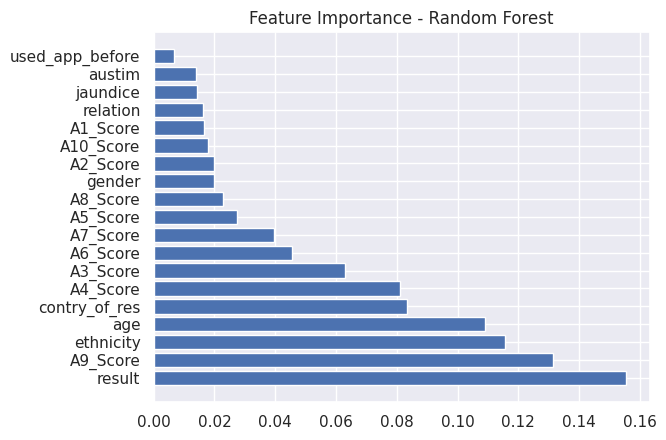

In [75]:
if isinstance(best_model, DecisionTreeClassifier):
    print("\nFeature Importance (Decision Tree):")
    feature_importance = best_model.feature_importances_
    feature_names = X_train_smote.columns
    importance_sorted_idx = np.argsort(feature_importance)[::-1]
    plt.barh(feature_names[importance_sorted_idx], feature_importance[importance_sorted_idx])
    plt.title("Feature Importance - Decision Tree")
    plt.show()

# Feature importance for Random Forest
elif isinstance(best_model, RandomForestClassifier):
    print("\nFeature Importance (Random Forest):")
    feature_importance = best_model.feature_importances_
    feature_names = X_train_smote.columns
    importance_sorted_idx = np.argsort(feature_importance)[::-1]
    plt.barh(feature_names[importance_sorted_idx], feature_importance[importance_sorted_idx])
    plt.title("Feature Importance - Random Forest")
    plt.show()

# Feature importance for CatBoost
elif isinstance(best_model, CatBoostClassifier):
    print("\nFeature Importance (CatBoost):")
    feature_importance = best_model.get_feature_importance()
    feature_names = X_train_smote.columns
    importance_sorted_idx = np.argsort(feature_importance)[::-1]
    plt.barh(feature_names[importance_sorted_idx], feature_importance[importance_sorted_idx])
    plt.title("Feature Importance - CatBoost")
    plt.show()


Evaluating Decision Tree:
Decision Tree Precision: 0.5000
Decision Tree Recall: 0.5000
Decision Tree F1-Score: 0.5000

Decision Tree Cross-Validation Scores: 0.8438
Decision Tree Mean CV Accuracy: 0.8078

ROC AUC Score for Decision Tree: 0.6774193548387096

Decision Tree Test Accuracy: 0.7750

Decision Tree Train Accuracy: 1.0000

Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       124
           1       0.50      0.50      0.50        36

    accuracy                           0.78       160
   macro avg       0.68      0.68      0.68       160
weighted avg       0.78      0.78      0.78       160


Decision Tree Test Sensitivity (Recall): 0.5000
Decision Tree Test Specificity: 0.8548
Decision Tree Train Sensitivity (Recall): 1.0000
Decision Tree Train Specificity: 1.0000
--------------------------------------------------


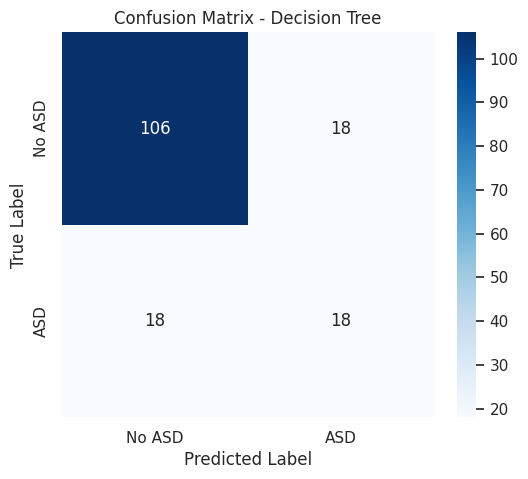

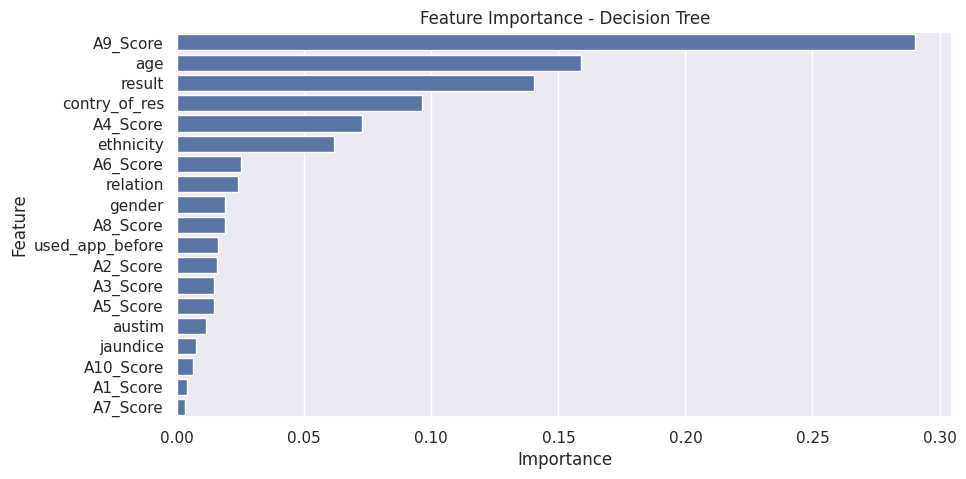


Evaluating Random Forest:
Random Fores Precision: 0.5897
Random Fores Recall: 0.6389
Random Fores F1-Score: 0.6133

Random Fores Cross-Validation Scores: 0.8594
Random Fores Mean CV Accuracy: 0.8438

ROC AUC Score for Random Forest: 0.7549283154121864

Random Forest Test Accuracy: 0.8187

Random Forest Train Accuracy: 1.0000

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       124
           1       0.59      0.64      0.61        36

    accuracy                           0.82       160
   macro avg       0.74      0.75      0.75       160
weighted avg       0.82      0.82      0.82       160


Random Forest Test Sensitivity (Recall): 0.6389
Random Forest Test Specificity: 0.8710
Random Forest Train Sensitivity (Recall): 1.0000
Random Forest Train Specificity: 1.0000
--------------------------------------------------


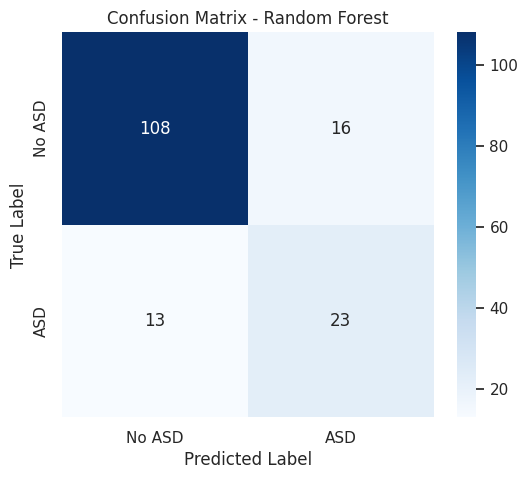

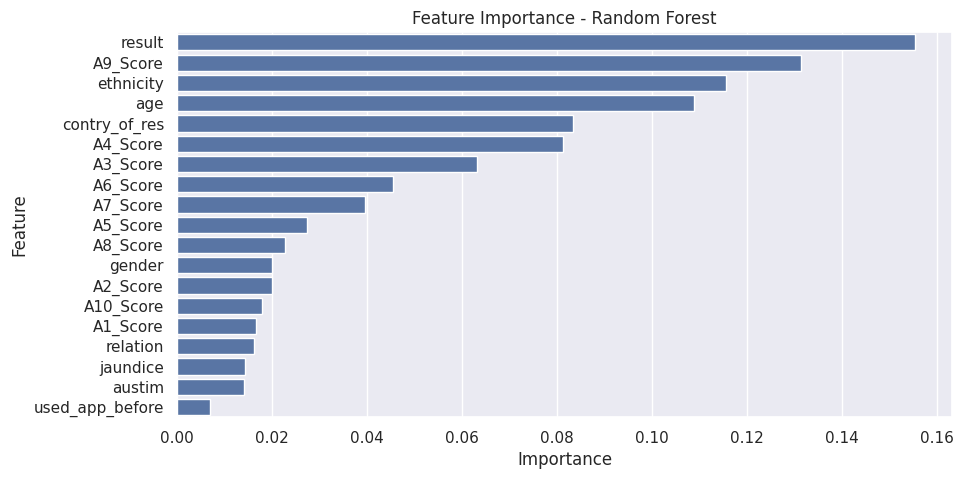


Evaluating CatBoost:
CatBoost Precision: 0.5122
CatBoost Recall: 0.5833
CatBoost F1-Score: 0.5455

CatBoost Cross-Validation Scores: 0.8906
CatBoost Mean CV Accuracy: 0.8641

ROC AUC Score for CatBoost: 0.7110215053763441

CatBoost Test Accuracy: 0.7812

CatBoost Train Accuracy: 1.0000

Classification Report for CatBoost:
               precision    recall  f1-score   support

           0       0.87      0.84      0.86       124
           1       0.51      0.58      0.55        36

    accuracy                           0.78       160
   macro avg       0.69      0.71      0.70       160
weighted avg       0.79      0.78      0.79       160


CatBoost Test Sensitivity (Recall): 0.5833
CatBoost Test Specificity: 0.8387
CatBoost Train Sensitivity (Recall): 1.0000
CatBoost Train Specificity: 1.0000
--------------------------------------------------


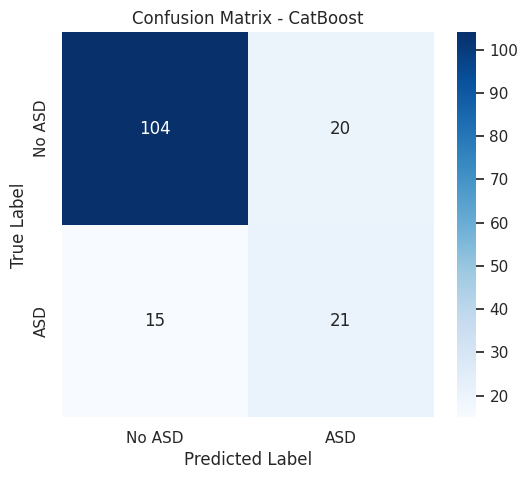

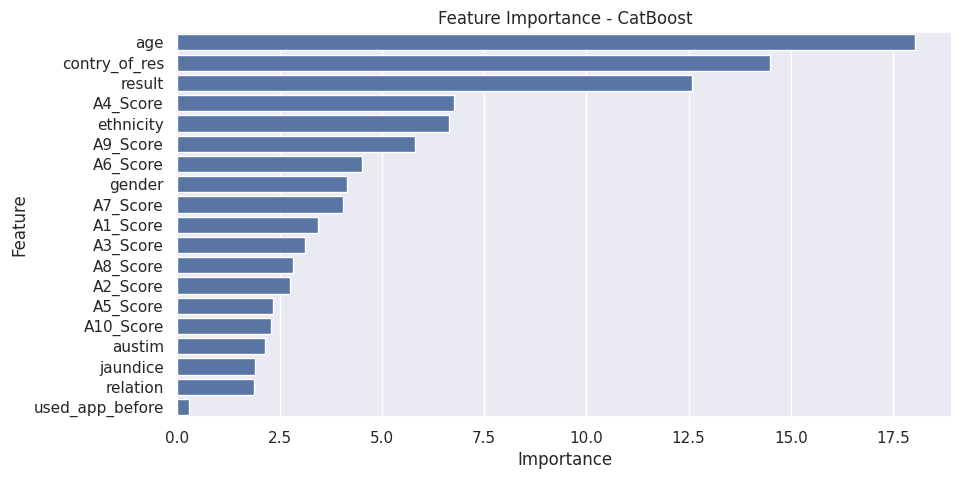

In [78]:
print("\nEvaluating Decision Tree:")
y_pred_dt = random_search_dt.best_estimator_.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
y_train_pred_dtml = random_search_dt.best_estimator_.predict(X_train)
accuracy_train_dtml = accuracy_score(y_train, y_train_pred_dtml)
cv_scores_dt = cross_val_score(random_search_dt.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_score_dt = f1_score(y_test, y_pred_dt)

print(f"Decision Tree Precision: {precision_dt:.4f}")
print(f"Decision Tree Recall: {recall_dt:.4f}")
print(f"Decision Tree F1-Score: {f1_score_dt:.4f}")
print(f"\nDecision Tree Cross-Validation Scores: {cv_scores_dt.max():.4f}")
print(f"Decision Tree Mean CV Accuracy: {cv_scores_dt.mean():.4f}")
print("\nROC AUC Score for Decision Tree:", roc_auc_score(y_test, y_pred_dt))
print(f"\nDecision Tree Test Accuracy: {accuracy_dt:.4f}")
print(f"\nDecision Tree Train Accuracy: {accuracy_train_dtml:.4f}")
print("\nClassification Report for Decision Tree:\n", classification_report(y_test, y_pred_dt))

# Sensitivity & Specificity for Decision Tree
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(y_test, y_pred_dt).ravel()
sensitivity_test_dt = tp_dt / (tp_dt + fn_dt)
specificity_test_dt = tn_dt / (tn_dt + fp_dt)

tn_train_dt, fp_train_dt, fn_train_dt, tp_train_dt = confusion_matrix(y_train, y_train_pred_dtml).ravel()
sensitivity_train_dt = tp_train_dt / (tp_train_dt + fn_train_dt)
specificity_train_dt = tn_train_dt / (tn_train_dt + fp_train_dt)

print(f"\nDecision Tree Test Sensitivity (Recall): {sensitivity_test_dt:.4f}")
print(f"Decision Tree Test Specificity: {specificity_test_dt:.4f}")
print(f"Decision Tree Train Sensitivity (Recall): {sensitivity_train_dt:.4f}")
print(f"Decision Tree Train Specificity: {specificity_train_dt:.4f}")
print("-" * 50)

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()


# Feature Importance for Decision Tree
feature_importance_dt = pd.DataFrame({
    "Feature": X_train_smote.columns,
    "Importance": random_search_dt.best_estimator_.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_dt)
plt.title("Feature Importance - Decision Tree")
plt.show()

# Evaluating Random Forest
print("\nEvaluating Random Forest:")
y_pred_rf = random_search_rf.best_estimator_.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
y_train_pred_rfml = random_search_dt.best_estimator_.predict(X_train)
accuracy_train_rfml = accuracy_score(y_train, y_train_pred_rfml)
cv_scores_rf = cross_val_score(random_search_rf.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_score_rf = f1_score(y_test, y_pred_rf)

print(f"Random Fores Precision: {precision_rf:.4f}")
print(f"Random Fores Recall: {recall_rf:.4f}")
print(f"Random Fores F1-Score: {f1_score_rf:.4f}")
print(f"\nRandom Fores Cross-Validation Scores: {cv_scores_rf.max():.4f}")
print(f"Random Fores Mean CV Accuracy: {cv_scores_rf.mean():.4f}")
print("\nROC AUC Score for Random Forest:", roc_auc_score(y_test, y_pred_rf))
print(f"\nRandom Forest Test Accuracy: {accuracy_rf:.4f}")
print(f"\nRandom Forest Train Accuracy: {accuracy_train_rfml:.4f}")
print("\nClassification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

# Sensitivity & Specificity for Random Forest
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, y_pred_rf).ravel()
sensitivity_test_rf = tp_rf / (tp_rf + fn_rf)
specificity_test_rf = tn_rf / (tn_rf + fp_rf)

tn_train_rf, fp_train_rf, fn_train_rf, tp_train_rf = confusion_matrix(y_train, y_train_pred_rfml).ravel()
sensitivity_train_rf = tp_train_rf / (tp_train_rf + fn_train_rf)
specificity_train_rf = tn_train_rf / (tn_train_rf + fp_train_rf)

print(f"\nRandom Forest Test Sensitivity (Recall): {sensitivity_test_rf:.4f}")
print(f"Random Forest Test Specificity: {specificity_test_rf:.4f}")
print(f"Random Forest Train Sensitivity (Recall): {sensitivity_train_rf:.4f}")
print(f"Random Forest Train Specificity: {specificity_train_rf:.4f}")
print("-" * 50)

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


# Feature Importance for Random Forest
feature_importance_rf = pd.DataFrame({
    "Feature": X_train_smote.columns,
    "Importance": random_search_rf.best_estimator_.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_rf)
plt.title("Feature Importance - Random Forest")
plt.show()

# Evaluating CatBoost
print("\nEvaluating CatBoost:")
y_pred_cat = random_search_cat.best_estimator_.predict(X_test)
accuracy_cat = accuracy_score(y_test, y_pred_cat)
y_train_pred_catml = random_search_dt.best_estimator_.predict(X_train)
accuracy_train_catml = accuracy_score(y_train, y_train_pred_catml)
cv_scores_cat = cross_val_score(random_search_cat.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
precision_cb = precision_score(y_test, y_pred_cat)
recall_cb = recall_score(y_test, y_pred_cat)
f1_score_cb = f1_score(y_test, y_pred_cat)

print(f"CatBoost Precision: {precision_cb:.4f}")
print(f"CatBoost Recall: {recall_cb:.4f}")
print(f"CatBoost F1-Score: {f1_score_cb:.4f}")
print(f"\nCatBoost Cross-Validation Scores: {cv_scores_cat.max():.4f}")
print(f"CatBoost Mean CV Accuracy: {cv_scores_cat.mean():.4f}")
print("\nROC AUC Score for CatBoost:", roc_auc_score(y_test, y_pred_cat))
print(f"\nCatBoost Test Accuracy: {accuracy_cat:.4f}")
print(f"\nCatBoost Train Accuracy: {accuracy_train_catml:.4f}")
print("\nClassification Report for CatBoost:\n", classification_report(y_test, y_pred_cat))

# Sensitivity & Specificity for CatBoost
tn_cat, fp_cat, fn_cat, tp_cat = confusion_matrix(y_test, y_pred_cat).ravel()
sensitivity_test_cat = tp_cat / (tp_cat + fn_cat)
specificity_test_cat = tn_cat / (tn_cat + fp_cat)

tn_train_cat, fp_train_cat, fn_train_cat, tp_train_cat = confusion_matrix(y_train, y_train_pred_catml).ravel()
sensitivity_train_cat = tp_train_cat / (tp_train_cat + fn_train_cat)
specificity_train_cat = tn_train_cat / (tn_train_cat + fp_train_cat)

print(f"\nCatBoost Test Sensitivity (Recall): {sensitivity_test_cat:.4f}")
print(f"CatBoost Test Specificity: {specificity_test_cat:.4f}")
print(f"CatBoost Train Sensitivity (Recall): {sensitivity_train_cat:.4f}")
print(f"CatBoost Train Specificity: {specificity_train_cat:.4f}")
print("-" * 50)
# Confusion Matrix for CatBoost
cm_cat = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cat, annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CatBoost")
plt.show()


# Feature Importance for CatBoost
feature_importance_cat = pd.DataFrame({
    "Feature": X_train_smote.columns,
    "Importance": random_search_cat.best_estimator_.get_feature_importance()
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_cat)
plt.title("Feature Importance - CatBoost")
plt.show()

**LightGBM**

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

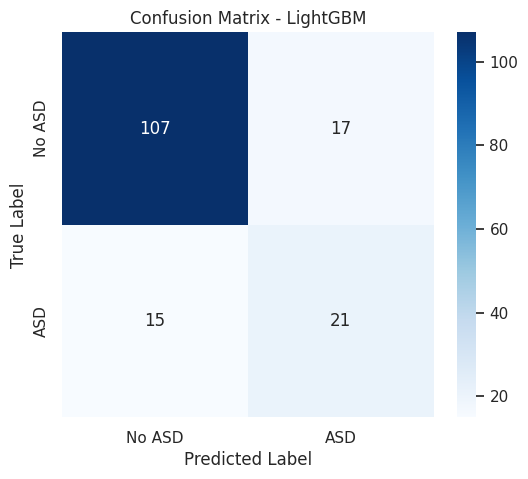

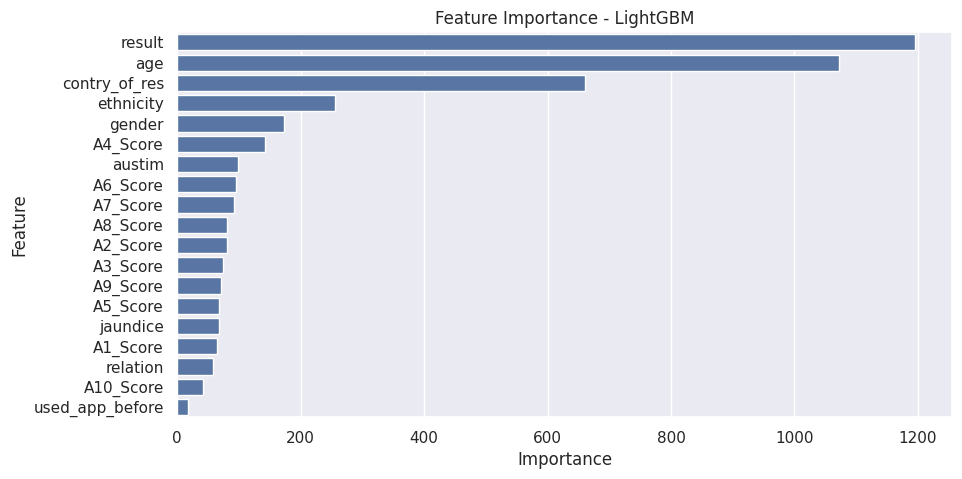

In [79]:
lgbm_model = lgb.LGBMClassifier(random_state=42)

# Hyperparameter grid for RandomizedSearchCV
param_grid_lgbm = {
    "num_leaves": [31, 50, 100],
    "max_depth": [10, 20, 30, -1],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 200, 500]
}

# Perform RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(estimator=lgbm_model, param_distributions=param_grid_lgbm, n_iter=20, cv=5, scoring="accuracy", random_state=42)
random_search_lgbm.fit(X_train_smote, y_train_smote)

# Print best parameters for LightGBM
#print(f"Best parameters for LightGBM:\n", random_search_lgbm.best_estimator_.get_params())

# Model Evaluation (for LightGBM)
y_pred_lgbm = random_search_lgbm.best_estimator_.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
y_train_pred_lgbmml = random_search_dt.best_estimator_.predict(X_train)
accuracy_train_lgbmml = accuracy_score(y_train, y_train_pred_lgbmml)
cv_scores_lb = cross_val_score(random_search_lgbm.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
precision_lb = precision_score(y_test, y_pred_lgbm)
recall_lb = recall_score(y_test, y_pred_lgbm)
f1_score_lb = f1_score(y_test, y_pred_lgbm)

print(f"LightGBM Precision: {precision_lb:.4f}")
print(f"LightGBM Recall: {recall_lb:.4f}")
print(f"LightGBM F1-Score: {f1_score_lb:.4f}")
print(f"\nLightGBM Cross-Validation Scores: {cv_scores_lb.max():.4f}")
print(f"LightGBM Mean CV Accuracy: {cv_scores_lb.mean():.4f}")
print("\nROC AUC Score for LightGBM:", roc_auc_score(y_test, y_pred_lgbm))
print(f"\nLightGBM Test Accuracy: {accuracy_lgbm:.4f}")
print(f"\nLightGBM Train Accuracy: {accuracy_train_lgbmml:.4f}")
print("\nClassification Report for LightGBM:\n", classification_report(y_test, y_pred_lgbm))

# Sensitivity & Specificity for LightGBM
tn_lgbm, fp_lgbm, fn_lgbm, tp_lgbm = confusion_matrix(y_test, y_pred_lgbm).ravel()
sensitivity_test_lgbm = tp_lgbm / (tp_lgbm + fn_lgbm)
specificity_test_lgbm = tn_lgbm / (tn_lgbm + fp_lgbm)

tn_train_lgbm, fp_train_lgbm, fn_train_lgbm, tp_train_lgbm = confusion_matrix(y_train, y_train_pred_lgbmml).ravel()
sensitivity_train_lgbm = tp_train_lgbm / (tp_train_lgbm + fn_train_lgbm)
specificity_train_lgbm = tn_train_lgbm / (tn_train_lgbm + fp_train_lgbm)

print(f"\nLightGBM Test Sensitivity (Recall): {sensitivity_test_lgbm:.4f}")
print(f"LightGBM Test Specificity: {specificity_test_lgbm:.4f}")
print(f"LightGBM Train Sensitivity (Recall): {sensitivity_train_lgbm:.4f}")
print(f"LightGBM Train Specificity: {specificity_train_lgbm:.4f}")
print("-" * 50)

# Confusion Matrix for LightGBM
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LightGBM")
plt.show()

# Feature Importance for LightGBM
feature_importance_lgbm = pd.DataFrame({
    "Feature": X_train_smote.columns,
    "Importance": random_search_lgbm.best_estimator_.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_lgbm)
plt.title("Feature Importance - LightGBM")
plt.show()

**LSTM**

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7018 - loss: 0.6547 - val_accuracy: 0.8313 - val_loss: 0.5340
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8499 - loss: 0.5082 - val_accuracy: 0.8313 - val_loss: 0.4160
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8292 - loss: 0.4204 - val_accuracy: 0.8313 - val_loss: 0.3810
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8440 - loss: 0.3751 - val_accuracy: 0.8250 - val_loss: 0.3793
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8326 - loss: 0.3707 - val_accuracy: 0.8313 - val_loss: 0.3699
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8361 - loss: 0.3642 - val_accuracy: 0.8250 - val_loss: 0.3703
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8497 - loss: 0.3417 - val_accuracy: 0.8375 - val_loss: 0.3679
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8526 - loss: 0.3468 - val_accuracy: 0.8438 - val_loss

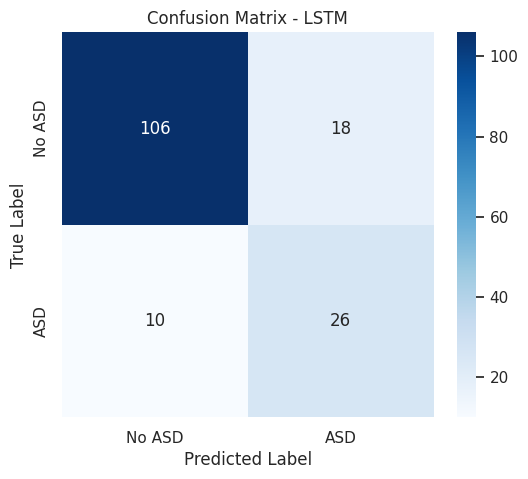

In [80]:
# Imputation and scaling
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_smote)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Reshape the data for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_lstm.fit(X_train_scaled, y_train_smote, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

# Validation accuracy at each epoch
val_accuracy = history.history['val_accuracy']
print("Validation Accuracy at each epoch: ")
for epoch, acc in enumerate(val_accuracy, start=1):
    print(f"Epoch {epoch}: {acc:.4f}")

# Final Validation Accuracy
print("*****LSTM Model*****")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")

# Predict and evaluate
y_train_pred_lstm = (model_lstm.predict(X_train_scaled) > 0.5).astype('int32')
y_test_pred_lstm = (model_lstm.predict(X_test_scaled) > 0.5).astype('int32')

# Accuracy and other metrics
train_accuracy_lstm = accuracy_score(y_train_smote, y_train_pred_lstm)
test_accuracy_lstm = accuracy_score(y_test, y_test_pred_lstm)
kappa = cohen_kappa_score(y_test, y_test_pred_lstm)
auc = roc_auc_score(y_test, model_lstm.predict(X_test_scaled))
# Precision, Recall, and F1-Score
precision_lstm = precision_score(y_test, y_test_pred_lstm)
recall_lstm = recall_score(y_test, y_test_pred_lstm)
f1_score_lstm = f1_score(y_test, y_test_pred_lstm)

print(f"LSTM Precision: {precision_lstm:.4f}")
print(f"LSTM Recall: {recall_lstm:.4f}")
print(f"LSTM F1-Score: {f1_score_lstm:.4f}")

print(f"Train Accuracy: {train_accuracy_lstm}")
print(f"Test Accuracy: {test_accuracy_lstm}")
print(f"Cohen's Kappa: {kappa}")
print(f"AUC: {auc}")
print("Classification report: \n", classification_report(y_test, y_test_pred_lstm))
print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_test_pred_lstm))

# Compute Sensitivity & Specificity for LSTM
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred_lstm).ravel()
sensitivity_test_lstm = tp_test / (tp_test + fn_test)
specificity_test_lstm = tn_test / (tn_test + fp_test)

tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train_smote, y_train_pred_lstm).ravel()
sensitivity_train_lstm = tp_train / (tp_train + fn_train)
specificity_train_lstm = tn_train / (tn_train + fp_train)

print(f"\nLSTM Test Sensitivity (Recall): {sensitivity_test_lstm:.4f}")
print(f"LSTM Test Specificity: {specificity_test_lstm:.4f}")
print(f"LSTM Train Sensitivity (Recall): {sensitivity_train_lstm:.4f}")
print(f"LSTM Train Specificity: {specificity_train_lstm:.4f}")
print("-" * 50)

cm_lstm = confusion_matrix(y_test, y_test_pred_lstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM")
plt.show()




**Bi- LSTM**

TensorFlow Version: 2.18.0
Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6915 - loss: 0.6507 - val_accuracy: 0.8438 - val_loss: 0.5159
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8315 - loss: 0.4903 - val_accuracy: 0.8250 - val_loss: 0.4200
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8323 - loss: 0.4057 - val_accuracy: 0.8250 - val_loss: 0.3916
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8288 - loss: 0.3830 - val_accuracy: 0.8313 - val_loss: 0.3843
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8272 - loss: 0.3710 - val_accuracy: 0.8313 - val_loss: 0.3800
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8269 - loss: 0.3642 - val_accuracy: 0.8313 - val_loss: 0.3765
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8288 - loss: 0.3599 - val_accuracy: 0.8313 - val_loss: 0.3734
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8276 - loss: 0.354

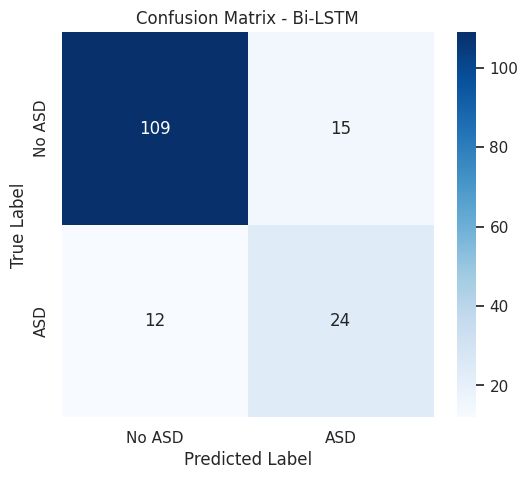

In [83]:
# # Impute Missing Values
# imputerval = SimpleImputer(strategy='mean')
# X_train_imputedval = imputerval.fit_transform(X_train_smote)
# X_test_imputedval = imputerval.transform(X_test)

# # Scaling Data
# scalerdata = StandardScaler()
# X_train_scaleddata = scalerdata.fit_transform(X_train_imputedval)
# X_test_scaleddata = scalerdata.transform(X_test_imputedval)

# # Reshaping for LSTM
# X_train_scaleddata = X_train_scaleddata.reshape((X_train_scaleddata.shape[0], 1, X_train_scaleddata.shape[1]))
# X_test_scaleddata = X_test_scaleddata.reshape((X_test_scaleddata.shape[0], 1, X_test_scaleddata.shape[1]))

# # Bi-LSTM Model
# model_bilstm = Sequential()
# model_bilstm.add(Bidirectional(LSTM(units=50, activation='relu', input_shape=(X_train_scaleddata.shape[1], X_train_scaleddata.shape[2]), return_sequences=False)))
# model_bilstm.add(Dropout(0.2))
# model_bilstm.add(Dense(1, activation='sigmoid'))
# model_bilstm.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Training the Model
# history_bilstm = model_bilstm.fit(X_train_scaleddata, y_train_smote, epochs=100, batch_size=32, validation_data=(X_test_scaleddata, y_test), verbose=1)

# # Model Evaluation
# val_accuracyeval = history_bilstm.history['val_accuracy']
# print("Validation Accuracy at each epoch: ")
# for epoch, acc in enumerate(val_accuracyeval, start=1):
#     print(f"Epoch {epoch}: {acc:.4f}")

# print("**Bi-LSTM Model**")
# print(f"Final Validation Accuracy: {val_accuracyeval[-1]:.4f}")

# y_train_pred_bilstm = (model_bilstm.predict(X_train_scaleddata) > 0.5).astype('int32')
# y_test_pred_bilstm = (model_bilstm.predict(X_test_scaleddata) > 0.5).astype('int32')

# train_accuracy_bilstm = accuracy_score(y_train_smote, y_train_pred_bilstm)
# test_accuracy_bilstm = accuracy_score(y_test, y_test_pred_bilstm)
# kappa_bilstm = cohen_kappa_score(y_test, y_test_pred_bilstm)
# auc_bilstm = roc_auc_score(y_test, model_bilstm.predict(X_test_scaleddata))
# # Precision, Recall, and F1-Score
# precision_bilstm = precision_score(y_test, y_test_pred_bilstm)
# recall_bilstm = recall_score(y_test, y_test_pred_bilstm)
# f1_score_bilstm = f1_score(y_test, y_test_pred_bilstm)

# print(f"BI-LSTM Precision: {precision_bilstm:.4f}")
# print(f"BI-LSTM Recall: {recall_bilstm:.4f}")
# print(f"BI-LSTM F1-Score: {f1_score_bilstm:.4f}")
# print(f"Train Accuracy: {train_accuracy_bilstm}")
# print(f"Test Accuracy: {test_accuracy_bilstm}")
# print(f"Cohen's Kappa: {kappa_bilstm}")
# print(f"AUC: {auc_bilstm}")
# print("Classification report: \n", classification_report(y_test, y_test_pred_bilstm))
# print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_test_pred_bilstm))

# # Compute Sensitivity & Specificity for Bi-LSTM
# tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred_bilstm).ravel()
# sensitivity_test_bilstm = tp_test / (tp_test + fn_test)  # Recall
# specificity_test_bilstm = tn_test / (tn_test + fp_test)

# tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train_smote, y_train_pred_bilstm).ravel()
# sensitivity_train_bilstm = tp_train / (tp_train + fn_train)  # Recall
# specificity_train_bilstm = tn_train / (tn_train + fp_train)

# print(f"\nBi-LSTM Test Sensitivity (Recall): {sensitivity_test_bilstm:.4f}")
# print(f"Bi-LSTM Test Specificity: {specificity_test_bilstm:.4f}")
# print(f"Bi-LSTM Train Sensitivity (Recall): {sensitivity_train_bilstm:.4f}")
# print(f"Bi-LSTM Train Specificity: {specificity_train_bilstm:.4f}")
# print("-" * 50)


# cm_bilstm = confusion_matrix(y_test, y_test_pred_bilstm)
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm_bilstm, annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix - Bi-LSTM")
# plt.show()
import random
import tensorflow as tf
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# ✅ Print TensorFlow version
print("TensorFlow Version:", tf.__version__)

# ✅ Impute Missing Values
imputerval = SimpleImputer(strategy='mean')
X_train_imputedval = imputerval.fit_transform(X_train_smote)
X_test_imputedval = imputerval.transform(X_test)

# ✅ Scaling Data
scalerdata = StandardScaler()
X_train_scaleddata = scalerdata.fit_transform(X_train_imputedval)
X_test_scaleddata = scalerdata.transform(X_test_imputedval)

# ✅ Convert to float32 for numerical stability
X_train_scaleddata = X_train_scaleddata.astype(np.float32)
X_test_scaleddata = X_test_scaleddata.astype(np.float32)

# ✅ Reshaping for LSTM
X_train_scaleddata = X_train_scaleddata.reshape((X_train_scaleddata.shape[0], 1, X_train_scaleddata.shape[1]))
X_test_scaleddata = X_test_scaleddata.reshape((X_test_scaleddata.shape[0], 1, X_test_scaleddata.shape[1]))

# ✅ Bi-LSTM Model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=50, activation='relu', input_shape=(X_train_scaleddata.shape[1], X_train_scaleddata.shape[2]), return_sequences=False)))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(1, activation='sigmoid'))
model_bilstm.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Training the Model (Ensuring batch order is fixed)
history_bilstm = model_bilstm.fit(X_train_scaleddata, y_train_smote, epochs=100, batch_size=32, validation_data=(X_test_scaleddata, y_test), verbose=1, shuffle=False)

# ✅ Model Evaluation
val_accuracyeval = history_bilstm.history['val_accuracy']
print("Validation Accuracy at each epoch: ")
for epoch, acc in enumerate(val_accuracyeval, start=1):
    print(f"Epoch {epoch}: {acc:.4f}")

print("**Bi-LSTM Model**")
print(f"Final Validation Accuracy: {val_accuracyeval[-1]:.4f}")

y_train_pred_bilstm = (model_bilstm.predict(X_train_scaleddata) > 0.5).astype('int32')
y_test_pred_bilstm = (model_bilstm.predict(X_test_scaleddata) > 0.5).astype('int32')

train_accuracy_bilstm = accuracy_score(y_train_smote, y_train_pred_bilstm)
test_accuracy_bilstm = accuracy_score(y_test, y_test_pred_bilstm)
kappa_bilstm = cohen_kappa_score(y_test, y_test_pred_bilstm)
auc_bilstm = roc_auc_score(y_test, model_bilstm.predict(X_test_scaleddata))

# ✅ Precision, Recall, and F1-Score
precision_bilstm = precision_score(y_test, y_test_pred_bilstm)
recall_bilstm = recall_score(y_test, y_test_pred_bilstm)
f1_score_bilstm = f1_score(y_test, y_test_pred_bilstm)

print("\n***** Bi-LSTM Model Performance *****")
print(f"Train Accuracy: {train_accuracy_bilstm:.4f}")
print(f"Test Accuracy: {test_accuracy_bilstm:.4f}")
print(f"Precision: {precision_bilstm:.4f}")
print(f"Recall: {recall_bilstm:.4f}")
print(f"F1-Score: {f1_score_bilstm:.4f}")
print(f"Cohen's Kappa: {kappa_bilstm:.4f}")
print(f"AUC: {auc_bilstm:.4f}")
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_test_pred_bilstm))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_bilstm))
print("-" * 50)

# ✅ Compute Sensitivity & Specificity for Bi-LSTM
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred_bilstm).ravel()
sensitivity_test_bilstm = tp_test / (tp_test + fn_test)  # Recall
specificity_test_bilstm = tn_test / (tn_test + fp_test)

tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train_smote, y_train_pred_bilstm).ravel()
sensitivity_train_bilstm = tp_train / (tp_train + fn_train)  # Recall
specificity_train_bilstm = tn_train / (tn_train + fp_train)

print(f"\nBi-LSTM Test Sensitivity (Recall): {sensitivity_test_bilstm:.4f}")
print(f"Bi-LSTM Test Specificity: {specificity_test_bilstm:.4f}")
print(f"Bi-LSTM Train Sensitivity (Recall): {sensitivity_train_bilstm:.4f}")
print(f"Bi-LSTM Train Specificity: {specificity_train_bilstm:.4f}")
print("-" * 50)

# ✅ Confusion Matrix
cm_bilstm = confusion_matrix(y_test, y_test_pred_bilstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bilstm, annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Bi-LSTM")
plt.show()

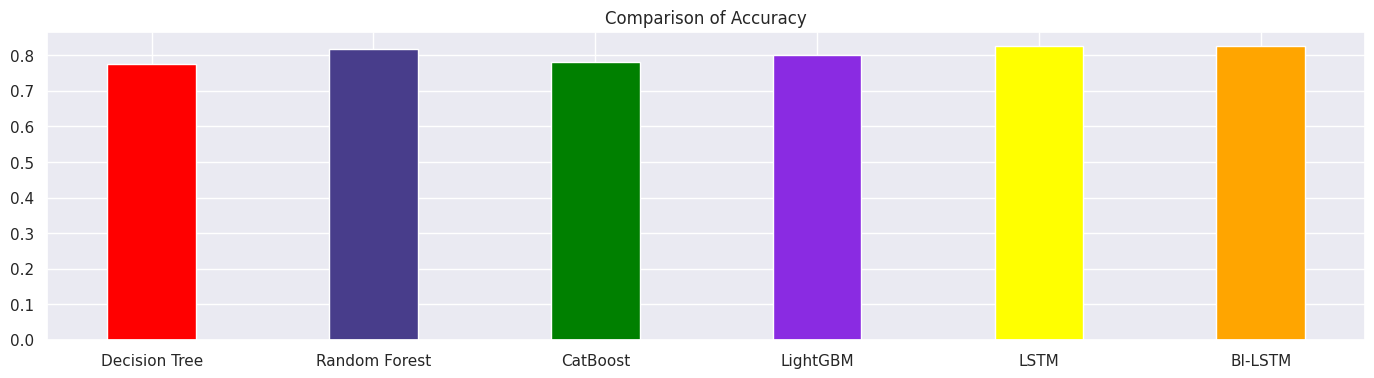

In [ ]:
#Comparison of Accuracy
fig, ax2 = plt.subplots(figsize = (17, 4))
ax2.bar(['Decision Tree', 'Random Forest','CatBoost', 'LightGBM', 'LSTM', 'BI-LSTM'], [accuracy_dt, accuracy_rf, accuracy_cat, accuracy_lgbm, test_accuracy_lstm, test_accuracy_bilstm], color=['red', 'darkslateblue', 'green', 'blueviolet', 'yellow', 'orange', ], width = 0.4)

plt.title('Comparison of Accuracy')
plt.show()